# Threshold de Classificação

# Setup

OBS: Instalar a lib yellowbrick

In [12]:
#descomente abaixo para instalar
#!pip install yellowbrick

In [22]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import auc, precision_recall_curve, log_loss,confusion_matrix, recall_score, precision_score
from sklearn.compose import ColumnTransformer
from yellowbrick.classifier import DiscriminationThreshold
import warnings
warnings.filterwarnings('ignore')

# Dados

In [14]:
df_churn = pd.read_csv('churn.csv')

In [15]:
df_churn['Churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: Churn, dtype: float64

## Divisão dos Dados

Fazendo seleção não estratificada

Divida seus dados de forma estratificada ```random_state=123``` e separe as colunas categóricas das numéricas em duas listas.

In [26]:
df_train, df_test = train_test_split(df_churn, 
                                     random_state=123, 
                                     test_size=0.3,
                                     stratify=df_churn['Churn'])

In [27]:
X_train, y_train = df_train.drop('Churn', axis=1), df_train['Churn']
X_test, y_test = df_test.drop('Churn', axis=1), df_test['Churn']

In [28]:
cat_columns_churn = X_train.select_dtypes(include=['object']).columns.tolist()
num_columns_churn = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Pipelines

Crie um pipeline para processamento dos dados de entrada. Primeiro crie um pipeline categórico com ```OneHotEncoder``` e depois um pipeline numérico com ```MinMaxScaler```

Combine tudo com o ```ColumnTransformer```

In [29]:
pipe_cat_columns_churn = ('one_hot_encoder' , 
                         OneHotEncoder(handle_unknown = 'ignore'),
                         cat_columns_churn)
pipe_num_columns_churn = ('min_max_scaler',
                         MinMaxScaler(),
                         num_columns_churn)

In [30]:
transformers = [pipe_num_columns_churn, pipe_cat_columns_churn]
pre_processor = ColumnTransformer(transformers)

# Modelagem

Compare os seguintes algoritmos, utilizando a métrica log loss.:
- Regressão Logística
- SVM
- KNN
- Decision Tree
- Random Forest

Construa um pipeline para cada um, utilizando o ```ColumnTransformer``` do passo anterior.

In [31]:
model_reglog = Pipeline(steps=[('pre_processor' , pre_processor),
                               ('model' , LogisticRegression(max_iter=5000, random_state =123))])
model_svm = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', SVC(kernel='rbf', probability=True, random_state=123))])
model_knn = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', KNeighborsClassifier())])
model_dt = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', DecisionTreeClassifier(max_depth=5,random_state=123))])
model_rf = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', RandomForestClassifier(max_depth=5,random_state=123))])

Vamos rodar todos os modelos e checar a performance com a log_loss. Dica, crie uma lista de modelos e rode um for loop.

In [32]:
classifiers = [model_reglog, model_svm, model_knn, model_dt, model_rf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    print(type(classifier['model']).__name__,'\n')
    print(f'log_loss treino: {log_loss(y_train, classifier.predict_proba(X_train)[:,1])}')
    print(f'log_loss teste: {log_loss(y_test, classifier.predict_proba(X_test)[:,1])}')
    print(100*'-')

LogisticRegression 

log_loss treino: 0.30979207068889475
log_loss teste: 0.3300326630641857
----------------------------------------------------------------------------------------------------
SVC 

log_loss treino: 0.22581375904953652
log_loss teste: 0.3009478987474056
----------------------------------------------------------------------------------------------------
KNeighborsClassifier 

log_loss treino: 0.22819266363858712
log_loss teste: 2.1372938720847334
----------------------------------------------------------------------------------------------------
DecisionTreeClassifier 

log_loss treino: 0.15662762654346146
log_loss teste: 0.4758465552296106
----------------------------------------------------------------------------------------------------
RandomForestClassifier 

log_loss treino: 0.24900873034753923
log_loss teste: 0.27758119283300287
----------------------------------------------------------------------------------------------------


Escolhemos o modelo Random Forest pois possui o menos Log Loss (Quanto menor o valor, mais perto do valor real ele esta)

# Avaliação do Threshold

Treine o modelo campeão.

In [33]:
model_rf.fit(X_train , y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Account length',
                                                   'Area code',
                                                   'Number vmail messages',
                                                   'Total day minutes',
                                                   'Total day calls',
                                                   'Total day charge',
                                                   'Total eve minutes',
                                                   'Total eve calls',
                                                   'Total eve charge',
                                                   'Total night minutes',
                                                   'Total night calls',
                                                   'Total night charge',
                                                   'Total intl minutes',
                                                   'Total intl calls',
                                                   'Total intl charge',
                                                   'Customer service calls']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('model',
                 RandomForestClassifier(max_depth=5, random_state=123))])

Avalie as métricas em relação ao threshold escolhido. Dica: use a biblioteca ```yellowbrick```

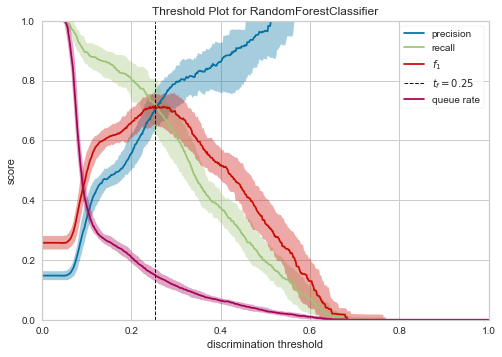

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [34]:
visualizer = DiscriminationThreshold(model_rf , cv=0.3)

visualizer.fit(X_train , y_train)
visualizer.show()

Com esse visualizador temos, além da mediana, uma banda que representa 90% de confiança

Como decidir o threshold? 

Isso vai depender da definição de sucesso escolhida lá no início do projeto!!

Se a ideia é aumentar a conversão, sem perder volume, devemos olhar pra pra queue rate e para precision!.

Vamos fazer um exercício para definir o threshold. 

Em tese, destes 1000, 145 irão desativar o produto da empresa. Devido ao coronavírus, a empresa decidiu reduzir o número de pessoas no customer service. Atualmente, 7 pessoas trabalham lá e em um mês, elas fazem em média 100 ligações. A taxa atual de precisão é 15%, ou seja, das 700 ligações por mês (considerando 1 ligação por cliente), eles conseguem recuperar 105 pessoas. A empresa pensa em demitir 2 pessoas e para isso, pediu que você desenvolvesse um modelo de churn para auxiliar a operação de customer service. 

Baseado nos resultados que tivemos, é possível demitir 2 pessoas, mantendo a mesma precisão e recuperando no mínimo o mesmo de antes? 

In [36]:
precision_atual = 0.15
clientes_recuperados = 700*15/100
recall_atual = clientes_recuperados/(145)

In [37]:
print(precision_atual)
print(recall_atual)

0.15
0.7241379310344828


Com 5 pessoas, temos apenas disponível 500 ligações por mês. Inicialmente vamos olhar quais são nossas métricas com uma queue rate equivalente.

In [38]:
queue_rate = 500/1000

In [39]:
filtro_queue_rate_05 = (visualizer.cv_scores_['queue_rate']<=queue_rate).tolist()
y_queue_rate_05 = visualizer.cv_scores_['queue_rate'][filtro_queue_rate_05]
y_precision_queue_rate_05 = visualizer.cv_scores_['precision'][filtro_queue_rate_05]
y_recall_queue_rate_05 = visualizer.cv_scores_['recall'][filtro_queue_rate_05]
x_threshold_queue_rate_05 = visualizer.thresholds_[filtro_queue_rate_05]

In [40]:
int(np.max(y_queue_rate_05)*1000)

498

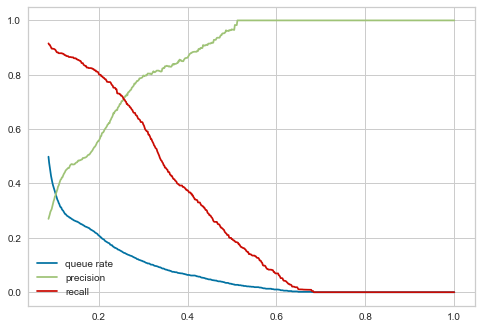

In [41]:
plt.plot(x_threshold_queue_rate_05, y_queue_rate_05, label='queue rate')
plt.plot(x_threshold_queue_rate_05, y_precision_queue_rate_05,label='precision')
plt.plot(x_threshold_queue_rate_05,y_recall_queue_rate_05, label='recall' )
x_threshold_queue_rate_05
plt.legend()
plt.show()

In [42]:
x_threshold_queue_rate_05[np.argmax(y_queue_rate_05)]

0.08726752503576538

Nossa resposta é SIM!. Com esse nosso modelinho já poderíamos demitir 2, aumentando a eficiência(conversão/precision) e aumentando a taxa de recuperação (recall).

Podemos ver esse problema de uma outra forma. E se em vez de responder a esse tipo de pergunta, quiséssemos escolher o threshold que permitisse que a empresa lucrasse mais?

Crie uma função de custo personalizada para o problema, levando em conta falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos e escolha o threshold que maximiza ou minimiza essa função (dependendo do problema). Qual o impacto financeiro de um Falso Positivo? E de um Falso Negativo? E de um Verdadeiro Positivo? E de um Verdadeiro Negativo?

Para esse exercício, precisamos definir os custos e receita de cada componente da matriz de confusão.

**Verdadeiro Positivo:** O verdadeiro positivo é o cara que iria desativar o produto e foi identificado corretamente pelo modelo. Esse cara gasta em média R$ 150 por mês com o produto da empresa e tem uma probabilidade de 15 por cento de ser retido, caso liguem para ele. 

 

Dessa forma podemos criar uma expressão que traz em média o "custo" de um Verdadeiro Positivo. Lembrando que a ligação também tem um custo, que vamos admitir que seja de R$ 10,00. Dessa forma, a expressão para o Verdadeiro positivo fica:    
     VP = 0.15*150 - 10



**Falso Positivo**: O falso positivo insere o custo da ligação. Dessa forma  a expressão fica:
FP = 150 - 10

**Verdadeiro Negativo**: O verdadeiro negativo traz lucro para a empresa, pois consome em média 150 reais.<br>
VN = 150

**Falso Negativo**: Por fim, o Falso Negativo é o cara que simplesmente deixa o produto e não transaciona mais, vamos admitir que é uma perda para a empresa. Como cada cliente transaciona em média 150 reais, a empresa terá uma perda equivalente.
<br>
FN = -150

In [43]:
tp_value = 0.15*150 - 10
fp_value = 140
tn_value = 150
fn_value = -150

In [44]:
uniform_thresholds = np.linspace(0, 1, 101)
profit_thresholds = []
recall_scores = []
precision_scores = []
queue_rates = []

In [45]:
for thresh in uniform_thresholds:
    decision = model_rf.predict_proba(X_test)[:,1]>=thresh
    
    tn, fp, fn, tp = confusion_matrix(y_test, model_rf.predict_proba(X_test)[:,1]>=thresh).ravel()
    profit = tn*tn_value + tp*tp_value + fn*fn_value + fp*fp_value
    profit_thresholds.append(profit)
    recall_scores.append(recall_score(y_test, decision))
    precision_scores.append(precision_score(y_test, decision))
    queue_rates.append(decision.sum()/len(y_test))

In [46]:
print(f'Se não fizermos nada, nosso lucro será: {(len(y_test)-y_test.sum())*150 - (y_test.sum())*150}')

Se não fizermos nada, nosso lucro será: 106500


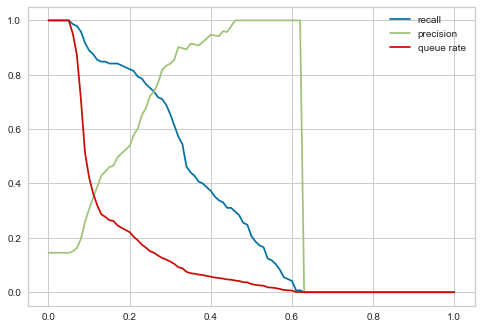

In [47]:
#plt.plot(uniform_thresholds, profit_thresholds, label='profit')
plt.plot(uniform_thresholds, recall_scores, label='recall')
plt.plot(uniform_thresholds, precision_scores, label='precision')
plt.plot(uniform_thresholds, queue_rates, label='queue rate')
plt.legend()
plt.show()

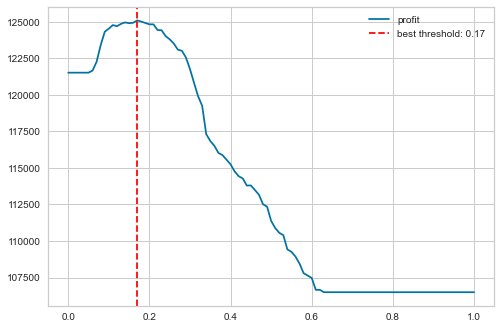

In [48]:
best_thresh = uniform_thresholds[np.argmax(profit_thresholds)]
plt.plot(uniform_thresholds, profit_thresholds, label='profit')
plt.axvline(best_thresh,linestyle= '--', color='red',label=f'best threshold: {best_thresh}')
plt.legend()
plt.show()

In [49]:
print(f'Lucro no melhor threshold: {profit_thresholds[np.argmax(profit_thresholds)]}')

Lucro no melhor threshold: 125085.0
